In [1]:
### Instalacion

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
import torch; torch._dynamo.config.recompile_limit = 64;

In [3]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [4]:
# Imports

In [5]:
from unsloth import FastModel
import unsloth
import torch

# Now, import other libraries
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from functools import partial
from datetime import datetime

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
### Cargar dataset

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [9]:


ruta = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
df = pd.read_csv(ruta, encoding='utf-8')

# Mostrar las primeras filas
print(df.head())

                                                 url  \
0  http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3...   
1  http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bj...   
2  http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgq...   
3              http://01anjali2001.github.io/netflix   
4  http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj...   

                                        html_content  \
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...   
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...   
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...   
3      0004_01anjali2001.github.io_netflix/page.html   
4  0005_bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a...   

                                          screenshot  label  
0  0001_bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3td...      1  
1  0002_bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpd...      1  
2  0003_bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtu...      1  
3  0004_01anjali2001.github.io_netflix/screenshot...      1  
4  0005_bafybeid

In [10]:
# Eliminar filas con valores faltantes
df.dropna(inplace=True)

# Información general del dataset combinado
print(df.info())

# Estadísticas descriptivas
print(df.describe())

# Verificar valores faltantes
print(df.isnull().sum())

# Verificar la distribución de etiquetas
if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           1000 non-null   object
 1   html_content  1000 non-null   object
 2   screenshot    1000 non-null   object
 3   label         1000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
           label
count  1000.0000
mean      0.8000
std       0.4002
min       0.0000
25%       1.0000
50%       1.0000
75%       1.0000
max       1.0000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
1    800
0    200
Name: count, dtype: int64


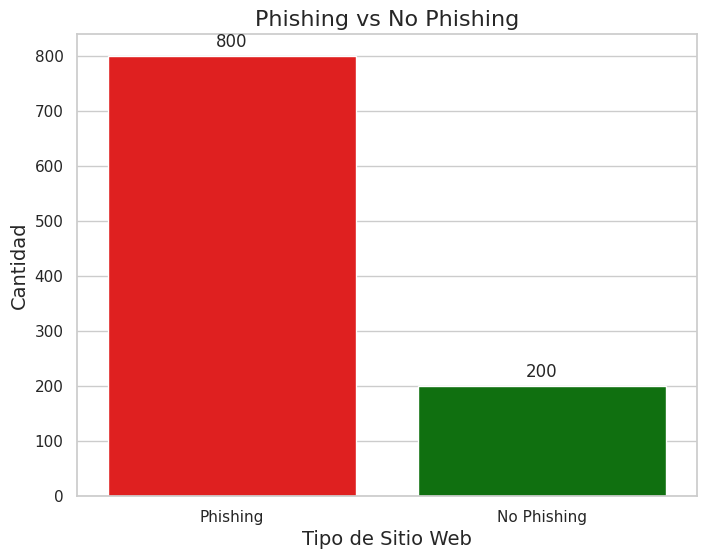

In [11]:
# Crear un diccionario para mapear las etiquetas
label_map = {0: 'No Phishing', 1: 'Phishing'}

# Crear una nueva columna con las etiquetas mapeadas
df['label_name'] = df['label'].map(label_map)

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

# Agregar título y etiquetas
plt.title('Phishing vs No Phishing', fontsize=16)
plt.xlabel('Tipo de Sitio Web', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

# Agregar los valores en las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

# Mostrar el gráfico
plt.show()

In [12]:
### Preparar metodos

In [13]:
def _configurar_modelo_unsloth(modelo_id: str):
    """Configura y carga el modelo Gemma 3 con Unsloth"""
    print(f"⚡ Configurando y cargando modelo Unsloth para {modelo_id}...")

    torch.cuda.empty_cache()

    # Cargar modelo y tokenizer con Unsloth
    model, tokenizer = FastModel.from_pretrained(
        model_name = "unsloth/gemma-3n-E4B-it",
        dtype = None, # None for auto detection
        max_seq_length = 1024, # Choose any for long context!
        load_in_4bit = True,  # 4 bit quantization to reduce memory
        full_finetuning = False, # [NEW!] We have full finetuning now!
        # token = "hf_...", # use one if using gated models
    )

    print(f"✅ Modelo '{modelo_id}' cargado correctamente con Unsloth.")
    return model, tokenizer

In [14]:
def _cargar_datos_fila(row: pd.Series, ruta_base: str):

    html_path = os.path.join(ruta_base, row['html_content'])
    screenshot_path = os.path.join(ruta_base, row['screenshot'])

    # Leer HTML
    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()

    # Cargar y preparar imagen
    screenshot = Image.open(screenshot_path).convert('RGB')
    if screenshot is None:
        raise ValueError(f"No se pudo cargar la imagen: {screenshot_path}")
    screenshot = screenshot.resize((512, 512)) # Redimensionar

    return html_content, screenshot

In [15]:
def prompt_option1_all(html_content: str, screenshot: Image.Image, url: str):
    """Construye el prompt para Gemma 3 con formato multimodal"""
    # Redimensionar imagen si es necesario
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [16]:
def prompt_option2_all(html_content: str, screenshot: Image.Image, url: str):
    """Construye el prompt para Gemma 3 con formato multimodal"""
    # Redimensionar imagen si es necesario
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
                    Act as a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
                    Consider:
                      1.Identification of the main brand the page is attempting to represent
                      2.Suspicious elements (credential fields, urgent calls to action)
                      3.Consistency between the identified brand and the displayed domain
                      4.Typical visual characteristics of phishing (low-quality logos, typographical errors)
                    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
                    """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [17]:
def prompt_option3_all(html_content: str, screenshot: Image.Image, url: str):
    """Construye el prompt para Gemma 3 con formato multimodal"""
    # Redimensionar imagen si es necesario
    screenshot = screenshot.resize((512, 512))

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": (
                    """
              [Context] You are a professional cybersecurity specialist reviewing websites to determinate if they are fishing or not. You will receive a URL, the HTML of the website and a screenshot.
              Follow this process:

                  Visual Analysis:
                      Identify the main visual elements (logos, colors, structure)
                      Look for inconsistencies in the design or low-quality elements
                      Detect any fields for entering sensitive data

                  Content Analysis:
                      Extract the main text and analyze its tone and content
                      Look for urgent language or threats
                      Verify consistency with the supposed brand

                  URL Analysis:
                      Examine the domain and compare it with the identified brand
                      Look for suspicious characters or typosquatting techniques

                  Conclusion:
                      Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name

              """
                    f"URL: {url}\n"
                    f"HTML extract: {html_content[:5000]}"
                )},
                {"type": "image", "image": screenshot}
            ]
        }
    ]

    return messages

In [18]:

def _generar_respuesta_gemma3(model, tokenizer, messages, max_new_tokens = 256):
    # Preparar el input del modelo con el chat template
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    )

    # Mover el input a la GPU si es necesario
    inputs = inputs.to("cuda")

    # Generar la respuesta sin un streamer
    # outputs = model.generate(
    #     **inputs,
    #     max_new_tokens=max_new_tokens,
    #     temperature=1.0,
    #     top_p=0.95,
    #     top_k=64,
    #     do_sample=True, # do_sample debe ser True para usar temperature, top_p, top_k
    #     pad_token_id=tokenizer.eos_token_id # Recomendado para evitar warnings
    # )

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,  # Para decodificación determinista (greedy)
        pad_token_id=tokenizer.eos_token_id  # Recomendado para evitar warnings
    )

    # Decodificar solo la parte nueva de la respuesta
    # La salida incluye el prompt original, así que lo decodificamos desde el final del prompt
    generated_text = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)

    return generated_text


In [25]:
def _procesar_fila_gemma3(row: pd.Series, model, tokenizer,
                         ruta_base: str, output_filepath: str, metodo_prompt_a_usar):
    """Procesa una fila con el modelo Gemma 3"""
    url = row.get('url', 'URL desconocida')
    label = row.get('label', 'Label desconocido')
    label_text = "PHISHING (true)" if label == 1 else "SAFE (false)"

    try:
        # 1. Cargar datos
        html_content, screenshot = _cargar_datos_fila(row, ruta_base)

        # 2. Construir prompt
        messages = metodo_prompt_a_usar(html_content, screenshot, url)

        # 3. Generar respuesta
        generated_text = _generar_respuesta_gemma3(model, tokenizer, messages)
        format_text = _procesar_generated_text_gemma3(generated_text)
        print(format_text)

        # 4. Loggear resultados
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(f"--- Salida para URL: {url} {label_text} ({timestamp}) ---")
        print(format_text[:500] + "..." if len(format_text) > 500 else format_text)
        print(f"--- Fin Salida ---")

        # 5. Guardar en archivo
        try:
            with open(output_filepath, 'a', encoding='utf-8') as f:
                f.write(f"URL: {url}\n")
                f.write(f"Resultado esperado: {label_text}\n")
                f.write(f"Salida: {format_text}\n")
                f.write("-" * 80 + "\n\n")
        except IOError as e:
            print(f"❌ Error escribiendo en archivo: {e}")

        return format_text

    except Exception as e:
        print(f"❌ Error procesando {url}: {type(e).__name__} - {e}")
        return f"Error: {str(e)}"

In [20]:
def _procesar_generated_text_gemma3(generated_text: str):
    """Procesa la respuesta de Gemma 3 para extraer solo el contenido del assistant"""
    # Buscar la parte del assistant en la respuesta
    if "assistant" in generated_text.lower():
        # Extraer el contenido después del último "assistant"
        parts = generated_text.split("assistant")
        if len(parts) > 1:
            return parts[-1].strip()

    return generated_text.strip()

In [26]:
def clasificador_gemma3(modelo_id: str, df: pd.DataFrame, ruta_base: str,
                       output_filepath: str, metodo_prompt_a_usar):
    """Función principal para clasificar con Gemma 3"""
    model = None
    tokenizer = None

    try:
        # 1. Configurar modelo
        model, tokenizer = _configurar_modelo_unsloth(modelo_id)

        # 2. Preparar función de procesamiento
        procesar_fila_con_contexto = partial(
            _procesar_fila_gemma3,
            model=model,
            tokenizer=tokenizer,
            ruta_base=ruta_base,
            output_filepath=output_filepath,
            metodo_prompt_a_usar=metodo_prompt_a_usar
        )

        # 3. Procesar todo el dataset
        print(f"🚀 Procesando {len(df)} filas con Gemma 3...")
        df['prediccion'] = df.apply(procesar_fila_con_contexto, axis=1)
        print("✅ Procesamiento completado.")

        return df

    except Exception as e:
        print(f"❌ Error crítico: {type(e).__name__} - {e}")
        return df

    finally:
        # 4. Liberar memoria
        if model is not None:
            print("🧹 Liberando modelo Gemma 3...")
            try:
                model.cpu()
                del model
            except:
                pass
            torch.cuda.empty_cache()
            print("✅ Memoria liberada.")

In [22]:
#EJECUCION

In [27]:

modelo_seleccionado = "unsloth/gemma-3n-E4B-it"

ruta_base_archivos = '/content/drive/MyDrive/Colab Notebooks/DatasetV1'
ruta_base_archivos = os.path.join(ruta_base_archivos, '')
ruta_csv = '/content/drive/MyDrive/Colab Notebooks/DatasetV1/datasetV1.csv'
ruta_directorio_salida = '/content/drive/MyDrive/Colab Notebooks'
df_datos = pd.read_csv(ruta_csv, encoding='utf-8')


metodos_prompt_gemma3 = [
    prompt_option1_all,
    prompt_option2_all,
    prompt_option3_all
]

print(f"\n===== Procesando Modelo: {modelo_seleccionado} =====")
nombre_base_archivo = modelo_seleccionado.split('/')[-1]

# Bucle sobre cada método de prompt
for i, metodo_prompt in enumerate(metodos_prompt_gemma3):
    # Obtener el nombre del método de la función
    nombre_metodo = metodo_prompt.__name__

    # Generar un nombre de archivo único para la combinación modelo y método
    # Se añade un índice 'i' para garantizar unicidad, aunque 'nombre_metodo' ya debería ser único.
    nombre_archivo_salida = f"{nombre_base_archivo}_{nombre_metodo}_resultados.txt"
    ruta_archivo_salida_final = os.path.join(ruta_directorio_salida, nombre_archivo_salida)

    print(f"  --- Ejecutando con método: {nombre_metodo} ---")
    print(f"  Guardando resultados en: {ruta_archivo_salida_final}")

    # Llamar a la función clasificadora
    # Asumo que 'clasificador_gemma3' debe aceptar el método de prompt como un argumento,
    # siguiendo el patrón del 'Segundo código'. He añadido 'metodo_prompt_a_usar'.
    df_resultado = clasificador_gemma3(
        modelo_id=modelo_seleccionado,
        df=df_datos,
        ruta_base=ruta_base_archivos,
        output_filepath=ruta_archivo_salida_final,
        metodo_prompt_a_usar=metodo_prompt # Nuevo argumento para el método de prompt
    )

    print(f"✅ Resultados guardados en {ruta_archivo_salida_final}")
    print("-" * 50)


===== Procesando Modelo: unsloth/gemma-3n-E4B-it =====
  --- Ejecutando con método: prompt_option1_all ---
  Guardando resultados en: /content/drive/MyDrive/Colab Notebooks/gemma-3n-E4B-it_prompt_option1_all_resultados.txt
⚡ Configurando y cargando modelo Unsloth para unsloth/gemma-3n-E4B-it...
==((====))==  Unsloth 2025.9.7: Fast Gemma3N patching. Transformers: 4.55.4.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to fast eager.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

✅ Modelo 'unsloth/gemma-3n-E4B-it' cargado correctamente con Unsloth.
🚀 Procesando 1000 filas con Gemma 3...
Legitimate
--- Salida para URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-25 11:05:35) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-25 11:05:37) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-25 11:05:38) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-25 11:05:44) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a5fovzmg52vaa2wcggu.ipfs.dweb.link PHISHING (true) (2025-09-25 11:05:46) ---
Legitimate
--- Fin Salida ---


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Modelo 'unsloth/gemma-3n-E4B-it' cargado correctamente con Unsloth.
🚀 Procesando 1000 filas con Gemma 3...
Phishing
--- Salida para URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-25 11:40:09) ---
Phishing
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-25 11:40:10) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-25 11:40:11) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-25 11:40:12) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a5fovzmg52vaa2wcggu.ipfs.dweb.link PHISHING (true) (2025-09-25 11:40:13) ---
Legitimate
--- Fin Salida ---
Legi

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Modelo 'unsloth/gemma-3n-E4B-it' cargado correctamente con Unsloth.
🚀 Procesando 1000 filas con Gemma 3...
Phishing
--- Salida para URL: http://bafybeicq2uxnud6qz2nlla7utndhtjtrugydx3tdzhjzj7zjx4jbffigie.ipfs.infura-ipfs.io PHISHING (true) (2025-09-25 12:00:34) ---
Phishing
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddrvh2jskkihnnlw4i4rs23m43bg56bjpdr43cfon6oddmha6lue.ipfs.dweb.link PHISHING (true) (2025-09-25 12:00:35) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeiddup6lnmz2bs3ywtoo7ygy7nuxzppsgqtuyzw54fpqryvosoumvu.ipfs.dweb.link PHISHING (true) (2025-09-25 12:00:36) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://01anjali2001.github.io/netflix PHISHING (true) (2025-09-25 12:00:37) ---
Legitimate
--- Fin Salida ---
Legitimate
--- Salida para URL: http://bafybeidoglaizl6f2nvlkf3n7aek4appfd4goj5a5fovzmg52vaa2wcggu.ipfs.dweb.link PHISHING (true) (2025-09-25 12:00:39) ---
Legitimate
--- Fin Salida ---
Phis